## Descrição do Notebook

1. Aplicação de Modelos

2. Avaliação dos Modelos

3. Problema de otmização

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
seed = 42

In [2]:
data = pd.read_csv('processed_data.csv')

In [3]:
data_train, data_test = train_test_split(data,test_size=0.2,random_state=42)

data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

X_train = data_train.drop('y',axis=1).copy()
y_train = data_train[['y']].copy()

X_test = data_test.drop('y',axis=1).copy()
y_test = data_test[['y']].copy()

### 1. Aplicação dos Modelos

1. kNN
2. Decision Tree
3. Naïve Bayes
4. SVM

> Uso de **Grid Search** para hiperparametrização e de **Cross Validation** para avaliação dos modelos

- Avalicação de voting (ensemble)

In [4]:
algorithms = {}

In [5]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
gscv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

1.1 kNN

In [6]:
from sklearn.neighbors import KNeighborsClassifier
algorithms['kNN'] =  GridSearchCV(
                                    KNeighborsClassifier(), 
                                    param_grid={
                                                'n_neighbors': [1, 3, 5],
                                                'p': [1, 2]
                                                },
                                    scoring='recall',
                                    cv=gscv
                                )

1.2 Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier
algorithms['tree'] =  GridSearchCV(
                                    DecisionTreeClassifier(random_state=seed), 
                                    param_grid={
                                                'max_depth': [3, 6, 12],
                                                'criterion': ['entropy', 'gini']
                                                },
                                    scoring='recall',
                                    cv=gscv
                                )

1.3 Naïve Bayes

In [8]:
from sklearn.naive_bayes import GaussianNB
algorithms['nb'] =  GridSearchCV(
                                    GaussianNB(), 
                                    param_grid={'var_smoothing': np.logspace(-8,-10, num=5)},
                                    scoring='recall',
                                    cv=gscv
                                )

1.4 Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegression
algorithms['lr'] =  GridSearchCV(
                                    LogisticRegression(random_state=seed, max_iter=1000), 
                                    param_grid={
                                                'penalty':['l2', 'none'],
                                                'tol': [1e-3, 1e-4],
                                                'solver': ['lbfgs', 'saga']
                                                },
                                    scoring='recall',
                                    cv=gscv
                                )

1.5 Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier
algorithms['rf'] =  GridSearchCV(
                                    RandomForestClassifier(), 
                                    param_grid={ 
                                                'n_estimators': [300, 250, 500, 600],
                                                'max_features': ['auto', 'sqrt', 'log2'],
                                                'max_depth' : [4,5,6,7,8],
                                                'criterion' :['gini', 'entropy']
                                            },
                                    scoring='recall',
                                    cv=gscv
                                )

1.6 Tunning dos Modelos

In [9]:
tunned_models = {}

In [10]:
for model in algorithms.keys():
    print('Grid Search -', model)
    tunned_models[model] = algorithms[model].fit(X_train.values, y_train['y'].values)
    print(model,'- Finished')

Grid Search - kNN
kNN - Finished
Grid Search - tree
tree - Finished
Grid Search - nb
nb - Finished


In [73]:
for model in ['lr','rf', 'voting']:
    print('Grid Search -', model)
    tunned_models[model] = algorithms[model].fit(X_train.values, y_train['y'].values)
    print(model,'- Finished')

Grid Search - lr
lr - Finished
Grid Search - rf


1.7 Método de Voting

In [ ]:
from sklearn.ensemble import VotingClassifier
tunned_models['voting'] = VotingClassifier(
                                                estimators = [(model, tunned_models[model]) for model in tunned_models.keys()],
                                                voting='soft'
                                            )

### 2. Avaliação dos Modelos

#### 2.1 Validação Cruzada

In [28]:
from sklearn.model_selection import cross_validate
gscv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [29]:
precision_scores = {}
accuracy_scores  = {}
recall_scores    = {}
f1_scores        = {}

In [30]:
for model in tunned_models.keys():
    print('Evaluation -', model)
    model_scores = cross_validate(tunned_models[model], 
                    X_train.values,
                    y_train['y'].values,
                    cv=gscv,
                    scoring = ['accuracy','precision', 'recall', 'f1']
                    )
    precision_scores[model] = model_scores['test_precision']
    accuracy_scores[model]  = model_scores['test_accuracy']
    recall_scores[model]    = model_scores['test_recall']
    f1_scores[model]        = model_scores['test_f1']
    print(model,'- Finished')

Evaluation - kNN
kNN - Finished
Evaluation - tree
tree - Finished
Evaluation - nb
nb - Finished
Evaluation - voting
voting - Finished


In [ ]:
for model in ['lr','rf', 'voting']:
    print('Evaluation -', model)
    model_scores = cross_validate(tunned_models[model], 
                    X_train.values,
                    y_train['y'].values,
                    cv=gscv,
                    scoring = ['accuracy','precision', 'recall', 'f1']
                    )
    precision_scores[model] = model_scores['test_precision']
    accuracy_scores[model]  = model_scores['test_accuracy']
    recall_scores[model]    = model_scores['test_recall']
    f1_scores[model]        = model_scores['test_f1']
    print(model,'- Finished')

In [31]:
precision_scores = pd.DataFrame(precision_scores)
accuracy_scores  = pd.DataFrame(accuracy_scores)
recall_scores    = pd.DataFrame(recall_scores)
f1_scores        = pd.DataFrame(f1_scores)

In [32]:
precision_scores.apply(lambda x: "{:.2f} ± {:.2f}".format(x.mean(), x.std()))

kNN       0.34 ± 0.02
tree      0.56 ± 0.02
nb        0.37 ± 0.02
voting    0.51 ± 0.02
dtype: object

In [33]:
accuracy_scores.apply(lambda x: "{:.2f} ± {:.2f}".format(x.mean(), x.std()))

kNN       0.85 ± 0.01
tree      0.89 ± 0.00
nb        0.85 ± 0.01
voting    0.89 ± 0.00
dtype: object

In [34]:
f1_scores.apply(lambda x: "{:.2f} ± {:.2f}".format(x.mean(), x.std()))

kNN       0.34 ± 0.02
tree      0.38 ± 0.02
nb        0.42 ± 0.02
voting    0.42 ± 0.02
dtype: object

In [35]:
recall_scores.apply(lambda x: "{:.2f} ± {:.2f}".format(x.mean(), x.std()))

kNN       0.34 ± 0.02
tree      0.29 ± 0.03
nb        0.48 ± 0.02
voting    0.36 ± 0.03
dtype: object

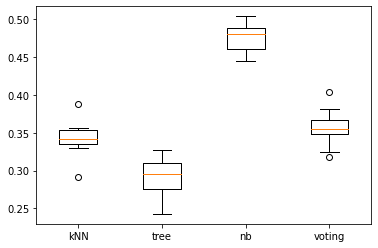

In [36]:
plt.boxplot([scores for alg, scores in recall_scores.iteritems() ])
plt.xticks(1 + np.arange(recall_scores.shape[1]), recall_scores.columns)
plt.show()

#### 2.2 Teste de Hipóteses

Para a comparação dos classificadores será utilizado o **Teste de Friedman**.

O teste de Friedman classifica os algoritmos do melhor ao pior em cada conjunto de dados em relação ao seu desempenho. 

Sua hipótese nula ($H_0$) afirma que todos os algoritmos **são equivalentes e seus ranks médios são iguais**. 


Se o teste de Friedman gerar um p-valor muito pequeno (menor que o nível de signficancia $\alpha$ = 0,05), podemos concluir que os desempenhos de todos os algoritmos não são equivalentes. 

In [37]:
from scipy.stats import friedmanchisquare, rankdata 

friedmanchisquare(*recall_scores.values)

FriedmanchisquareResult(statistic=19.75075987841945, pvalue=0.01951442037378944)

In [38]:
ranks = np.array([rankdata(-p) for p in recall_scores.values])

average_ranks = np.mean(ranks, axis=0) 
print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(tunned_models.keys(), average_ranks)))

kNN average rank: 2.7
tree average rank: 4.0
nb average rank: 1.0
voting average rank: 2.3


Como nem todos os classificadores são equivalentes, deverá ser feito um pós-teste.

Primeiramente será utilizado o teste de **Nemenyi**, onde:

    - Todos os classificadores são comparados entre si. 
    
Na sequência será utilizado um teste de **Bonferroni-Dunn**, onde:

    - Todos os classificadores são comparados a um classificador de controle. 

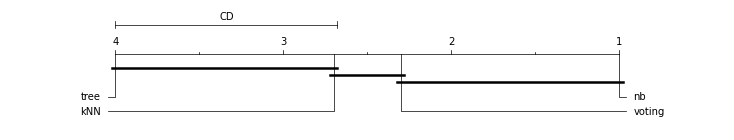

In [45]:
from Orange.evaluation import compute_CD, graph_ranks

#Teste de Nemenyi

#diferença crítica
cd = compute_CD(average_ranks, n=recall_scores.shape[0], alpha='0.1', test='nemenyi') 

#plot diagrama de diferença crítica
graph_ranks(average_ranks,
            names=list(tunned_models.keys()),
            cd=cd, 
            width=10, 
            textspace=1.5, 
            reverse=True) 

plt.show()

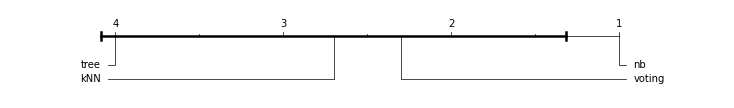

In [46]:
#Teste de Bonferroni-Dunn

#diferença crítica
cd = compute_CD(average_ranks, n=recall_scores.shape[0], alpha='0.05', test='bonferroni-dunn') 

#plot diagrama de diferença crítica
graph_ranks(average_ranks,
            names=list(tunned_models.keys()),
            cd=cd, 
            cdmethod=0,
            width=10, 
            textspace=1.5, 
            reverse=True) 

plt.show()

#### 2.3 Avaliação no Grupo de Teste

In [50]:
best_model = GaussianNB(var_smoothing = tunned_models['nb'].best_params_['var_smoothing'])
best_model.fit(X_train.values, y_train['y'].values)

GaussianNB(var_smoothing=1e-08)

### 3. Problema de Otimização

#### 3.1 Probabilidade Interna

In [66]:
probs_modelo = np.sort(best_model.predict_proba(X_test.values)[:,1])[::-1]
Qt = len(probs_modelo)
n = np.argwhere(probs_modelo > 0.4999).max()

print(f'De {Qt} pessoas, {best_model.predict(X_test.values).sum()} pessoas foram classificadas como potenciais compradores ({round(best_model.predict(X_test.values).sum()/Qt,4)*100}%).')

De 8238 pessoas, 1170 pessoas foram classificadas como potenciais compradores (14.2%).


C:\Users\pedro\AppData\Local\Temp/ipykernel_7232/4250863661.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt.plot([n, n], [0, 1.0],'k:', color ="red")


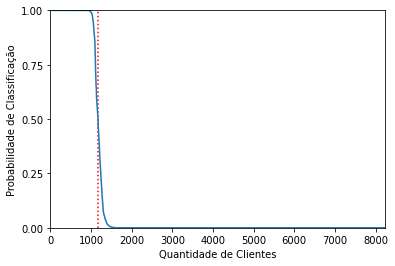

In [56]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0)

plt.xlabel('Quantidade de Clientes')
plt.ylabel('Probabilidade de Classificação')
plt.axis([0.0, Qt, 0, 1.0])
plt.plot([n, n], [0, 1.0],'k:', color ="red")

ax.set_yticks(np.linspace(0, 1, num=5))
plt.plot(probs_modelo)
plt.savefig("prob_interna.png")
plt.show()

#### 3.2 Calibração

In [57]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(base_estimator=best_model, method='isotonic', cv='prefit')
calibrated_clf.fit(X_train.values, y_train['y'].values)

CalibratedClassifierCV(base_estimator=GaussianNB(var_smoothing=1e-08),
                       cv='prefit', method='isotonic')

In [58]:
probs = calibrated_clf.predict_proba(X_test)[:,1]
probs = np.sort(probs)[::-1]

prob_media = probs[0:Qt+1].sum()/Qt
prob_media

c:\Users\pedro\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


0.11222743346107619

C:\Users\pedro\AppData\Local\Temp/ipykernel_7232/2889581323.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k:" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0.0, Qt], [prob_media, prob_media],'k:', color ="red")


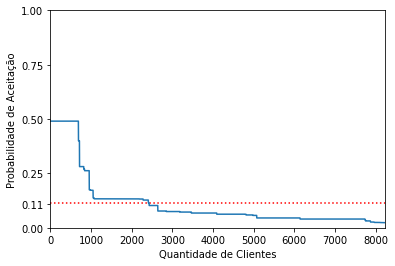

In [59]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0)

plt.xlabel('Quantidade de Clientes')
plt.ylabel('Probabilidade de Aceitação')
plt.axis([0.0, Qt, 0, 1.0])
plt.plot([0.0, Qt], [prob_media, prob_media],'k:', color ="red")

ax.set_yticks(np.append(np.linspace(0, 1, num=5), round(prob_media,2)))
plt.plot(probs)
plt.savefig("prob_calibrada.png")
plt.show()

### Formulação Matemática:

#### Definições Gerais:
- Custo por ligação: $c$
- Retorno para o banco por produto contratado: $r$
- Retorno total para o banco: $R$
- Quantidade de clientes: $q$
- Quantidade Total de clientes: $Q_t$
- Contratos Contratados: $c_c$
- Probabilidade de contratação do cliente $i$: $p_i$

#### Modelo de Negócios Atual:
- Quantidade atual de clientes: $Q_0 = Q_t$
- Retorno atual para o banco: $R_0$

Assim, se a porcentagem média de contratos é $p_m$ (~11.3%), espera-se receber:

$R_0  = rE[c_c] - cQ_t = Q_t(p_m r - c)$

#### Modelo de Negócios Sugerido:
- Quantidade de Clientes: $Q$
- Retorno atual para o banco: $R$

Nesse cenário:

- Quantidade de Contratos Contratados: $C_c = E[c_c] = \int p \; dq = \sum_{i = 1}^{Q} p_i$
- Custo total: $cQ$ 
- Retorno atual para o banco: $R = r\left(\sum_{i = 1}^{Q} p_i\right) - cQ  $

### Valores Adotados:

- Retorno líquido por venda: $r = 5.00 \text{ }R\$ $ 

- Custo por ligação: $c = 0.50 \text{ }R\$$ 

### Retorno Atual:

$R_0 = cQ_t = Q_t(p_m r - c) = 1161.00 R\$$

### Novo Retorno:

- Escolher $Q$  de modo que $R(Q) = \max R(q)$

In [60]:
c = 0.75
r = 5

#### Retorno Considerando Todas as Ligações para o Modelo Calibrado

In [61]:
prob_media = 0.113 # = probs[0:Qt+1].sum()/Qt

R0 = (r*prob_media-c)*Qt
print(f'O Atual retorno esperado é R0 = {R0:.2f} R$, no caso em que a quantidade de ligações é {Qt}.')

O Atual retorno esperado é R0 = -1524.03 R$, no caso em que a quantidade de ligações é 8238.


#### Maximizando o Retorno

In [62]:
# Novo Retorno Esperado
qmax = -1
Rmax = 0

for q in range(Qt):
    R = r*probs[0:q+1].sum()-c*q
    if R > Rmax:
        Rmax = R
        qmax = q + 1

print(f'O Máximo retorno esperado R = {Rmax:.2f} R$, ocorre para o caso em que a quantidade de ligações é {qmax}.')

O Máximo retorno esperado R = 1361.61 R$, ocorre para o caso em que a quantidade de ligações é 1049.


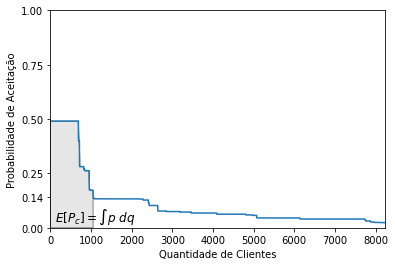

In [63]:
from matplotlib.patches import Polygon

fig, ax = plt.subplots()
ax.set_ylim(bottom=0)

plt.xlabel('Quantidade de Clientes')
plt.ylabel('Probabilidade de Aceitação')
plt.axis([0.0, Qt, 0, 1.0])

ax.text(1100, 0.03, r"$E[P_c] = \int p \; dq$", horizontalalignment='center', fontsize=12)
lim_x = qmax
ix = np.linspace(0, lim_x-1)
iy = np.take(probs, ix.astype(int))
verts = [(0, 0), *zip(ix, iy), (lim_x, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)

ax.set_yticks(np.append(np.linspace(0, 1, num=5), round(probs[qmax],2)))
plt.plot(probs)
plt.savefig("integral.png")
plt.show()